# Utility graph plot matrix

In [1]:
import matplotlib.pyplot as plt

def draw_graph(G, node_names={}, nodes_label=[], node_size=900):
    pos_nodes = nx.spring_layout(G)
    
    col = {0:"steelblue",1:"red",2:"green"}
    
    colors = [col[x] for x in nodes_label]
    
    nx.draw(G, pos_nodes, with_labels=True, node_color=colors, node_size=node_size, edge_color='gray', 
            arrowsize=30)
    
    
    
    pos_attrs = {}
    for node, coords in pos_nodes.items():
        pos_attrs[node] = (coords[0], coords[1] + 0.08)
        
    
    plt.axis('off')
    axis = plt.gca()
    axis.set_xlim([1.2*x for x in axis.get_xlim()])
    axis.set_ylim([1.2*y for y in axis.get_ylim()])
    plt.show()

# Label propagation

/home/deusebio/.pyenv/versions/graph-machine-learning/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:304: UserWarning: 

The arrowsize keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for arrowsize.
Note that using FancyArrowPatches may be slow for large graphs.

  draw_networkx_edges(G, pos, arrows=arrows, **edge_kwds)


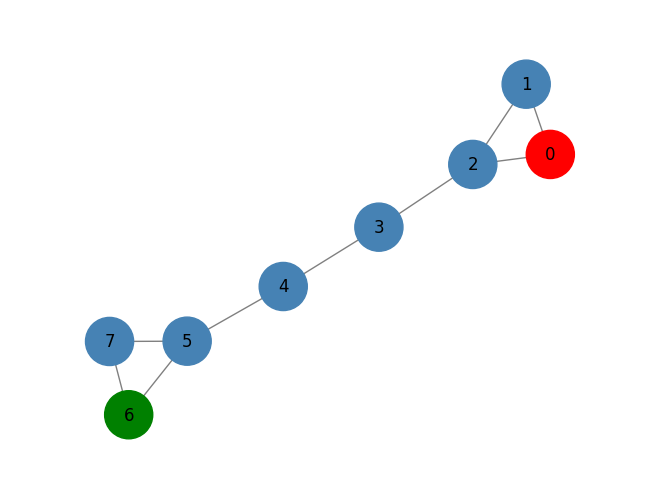

In [2]:
import networkx as nx

G = nx.barbell_graph(m1=3, m2=2)
nodes_label = [0 for x in range(len(G.nodes()))]
nodes_label[0] = 1
nodes_label[6] = 2
draw_graph(G, nodes_label=nodes_label, node_size=1200)

## Degree matrix

In [3]:
import numpy as np
from numpy.linalg import inv

D = [G.degree(n) for n in G.nodes()]
D = np.diag(D)
D

array([[2, 0, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0, 0, 0],
       [0, 0, 3, 0, 0, 0, 0, 0],
       [0, 0, 0, 2, 0, 0, 0, 0],
       [0, 0, 0, 0, 2, 0, 0, 0],
       [0, 0, 0, 0, 0, 3, 0, 0],
       [0, 0, 0, 0, 0, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 0, 2]])

## Proximity matrix

In [4]:
A = inv(D)*nx.to_numpy_matrix(G)
A

AttributeError: module 'networkx' has no attribute 'to_numpy_matrix'

## Label propagation implemenation

In [ ]:
import numpy as np
import networkx as nx
from numpy.linalg import inv
from abc import ABCMeta, abstractmethod
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.multiclass import check_classification_targets
from sklearn.utils.validation import check_is_fitted, _deprecate_positional_args

class GraphLabelPropagation(ClassifierMixin, BaseEstimator, metaclass=ABCMeta):
    """Graph label propagation module.
    Parameters
    ----------
    max_iter : int, default=30
        Change maximum number of iterations allowed.
    tol : float, default=1e-3
        Convergence tolerance: threshold to consider the system at steady
        state.
    """

    @_deprecate_positional_args
    def __init__(self, max_iter=30, tol=1e-3):

        self.max_iter = max_iter
        self.tol = tol

    def predict(self, X):
        """Performs inductive inference across the model.
        Parameters
        ----------
        X : A networkx array.
            The data matrix.
        Returns
        -------
        y : ndarray of shape (n_samples,)
            Predictions for input data.
        """
        probas = self.predict_proba(X)
        return self.classes_[np.argmax(probas, axis=1)].ravel()

    def predict_proba(self, X):
        """Predict probability for each possible outcome.
        Compute the probability estimates for each single node in X
        and each possible outcome seen during training (categorical
        distribution).
        Parameters
        ----------
        X : A networkx array.
        Returns
        -------
        probabilities : ndarray of shape (n_samples, n_classes)
            Normalized probability distributions across
            class labels.
        """
        check_is_fitted(self)
        
        return self.label_distributions_
    
    def _validate_data(self, X, y):
        if not isinstance(X, nx.Graph):
            raise ValueError("Input should be a networkX graph")
        if not len(y) == len(X.nodes()):
            raise ValueError("Label data input shape should be equal to the number of nodes in the graph")
        return X, y
    
    @staticmethod
    def build_label(x,classes):
        tmp = np.zeros((classes))
        tmp[x] = 1
        return tmp
    
    def fit(self, X, y):
        """Fit a semi-supervised label propagation model based
        on the input graph G and corresponding label matrix y with a dedicated marker value for
        unlabeled samples.
        Parameters
        ----------
        X : A networkX array.
        y : array-like of shape (n_samples,)
            `n_labeled_samples` (unlabeled points are marked as -1)
            All unlabeled samples will be transductively assigned labels.
        Returns
        -------
        self : object
        """
        X, y = self._validate_data(X, y)
        self.X_ = X
        check_classification_targets(y)

        D = [X.degree(n) for n in X.nodes()]
        D = np.diag(D)
        
        # label construction
        # construct a categorical distribution for classification only
        unlabeled_index = np.where(y==-1)[0]
        labeled_index = np.where(y!=-1)[0]
        unique_classes = np.unique(y[labeled_index])
        
        self.classes_ = unique_classes
        
        Y0 = np.array([self.build_label(y[x], len(unique_classes)) 
                                 if x in labeled_index else np.zeros(len(unique_classes)) for x in range(len(y))])
        
        A = inv(D)*nx.to_numpy_matrix(G)
        Y_prev = Y0
        it = 0
        c_tool = 10
        
        while it < self.max_iter & c_tool > self.tol:
            Y = A*Y_prev
            #force labeled nodes
            Y[labeled_index] = Y0[labeled_index]
            
            it +=1
            c_tol = np.sum(np.abs(Y-Y_prev))
            
            Y_prev = Y
            
        self.label_distributions_ = Y
        return self

## Label propagation execution

In [ ]:
glp = GraphLabelPropagation()
y = np.array([-1 for x in range(len(G.nodes()))])
y[0] = 1
y[6] = 0
glp.fit(G,y)
tmp = glp.predict(G)
print(glp.predict_proba(G))

draw_graph(G, nodes_label=tmp+1, node_size=1200)

# Label spreading

In [ ]:
import networkx as nx

G = nx.barbell_graph(m1=3, m2=2)
nodes_label = [0 for x in range(len(G.nodes()))]
nodes_label[0] = 1
nodes_label[6] = 2
draw_graph(G, nodes_label=nodes_label, node_size=1200)

## Degree matrix

In [ ]:
import numpy as np
from numpy.linalg import inv

D = [G.degree(n) for n in G.nodes()]
D = np.diag(D)
D

## Normalized graph Laplacian matrix

In [ ]:
from scipy.linalg import fractional_matrix_power
D_inv = fractional_matrix_power(D, -0.5)
L = D_inv*nx.to_numpy_matrix(G)*D_inv
L

## Label spreading implementation

In [ ]:
import numpy as np
import networkx as nx
from sklearn.preprocessing import normalize
from scipy.linalg import fractional_matrix_power
from sklearn.utils.multiclass import check_classification_targets

class GraphLabelSpreading(GraphLabelPropagation):
    """Graph label propagation module.
    Parameters
    ----------
    max_iter : int, default=30
        Change maximum number of iterations allowed.
    tol : float, default=1e-3
        Convergence tolerance: threshold to consider the system at steady
        state.
    """

    @_deprecate_positional_args
    def __init__(self, max_iter=30, tol=1e-3, alpha=0.6):

        self.alpha = alpha
        super().__init__(max_iter, tol)
    
    def fit(self, X, y):
        """Fit a semi-supervised label propagation model based
        on the input graph G and corresponding label matrix y with a dedicated marker value for
        unlabeled samples.
        Parameters
        ----------
        X : A networkX array.
        y : array-like of shape (n_samples,)
            `n_labeled_samples` (unlabeled points are marked as -1)
            All unlabeled samples will be transductively assigned labels.
        Returns
        -------
        self : object
        """
        X, y = self._validate_data(X, y)
        self.X_ = X
        check_classification_targets(y)

        D = [X.degree(n) for n in X.nodes()]
        D = np.diag(D)
        D_inv = np.matrix(fractional_matrix_power(D,-0.5))
        L = D_inv*nx.to_numpy_matrix(G)*D_inv
        
        # label construction
        # construct a categorical distribution for classification only
        unlabeled_index = np.where(y==-1)[0]
        labeled_index = np.where(y!=-1)[0]
        unique_classes = np.unique(y[labeled_index])
        
        self.classes_ = unique_classes
        
        Y0 = np.array([self.build_label(y[x], len(unique_classes)) 
                                 if x in labeled_index else np.zeros(len(unique_classes)) for x in range(len(y))])
        
        Y_prev = Y0
        it = 0
        c_tool = 10
        
        while it < self.max_iter & c_tool > self.tol:
            Y = self.alpha*(L*Y_prev)+((1-self.alpha)*Y0)

            it +=1
            c_tol = np.sum(np.abs(Y-Y_prev))
            Y_prev = Y
        self.label_distributions_ = Y
        return self

# Label Spreading

In [ ]:
gls = GraphLabelSpreading(max_iter=1000)
y = np.array([-1 for x in range(len(G.nodes()))])
y[0] = 1
y[6] = 0
gls.fit(G,y)
tmp = gls.predict(G)
print(gls.predict_proba(G))
draw_graph(G, nodes_label=tmp+1, node_size=1200)